## Initialize everything

In [1]:
import pyapr
import numpy as np
from skimage.io import imsave, imread
import matplotlib.pyplot as plt

def are_labels_the_same(local_labels):
    labels = local_labels[local_labels != 0].flatten()
    return ((labels == labels[0]).all(), labels[0])


# APR file to segment
fpath_apr = r'/media/sf_shared_folder_virtualbox/mouse_2P/data1/2P_mouse_re0.2.apr'
fpath_labels = r'/media/sf_shared_folder_virtualbox/mouse_2P/data1/manual_sparse_labels_membrane.npy'

# Instantiate APR and particle objects
apr = pyapr.APR()
parts = pyapr.ShortParticles()  # input particles can be float32 or uint16
labels = np.load(fpath_labels).squeeze().astype('uint16') # 0: not labeled - 1: cells - 2: background

# Read from APR file
pyapr.io.read(fpath_apr, apr, parts)

## Perform segmentation on APR

In [2]:
# Iterate over APR structure to obtain level
apr_it = apr.iterator()
org_dims = apr.org_dims()  # dimension order (y, x, z)
py_recon = np.empty((org_dims[2], org_dims[1], org_dims[0]), dtype=np.uint16)
max_level = apr.level_max()

# particles at the maximum level coincide with pixels so we just assign the label
parts_train_C = pyapr.ShortParticles()
pyapr.io.read(fpath_apr, apr, parts_train_C)
parts_train = np.array(parts_train_C, copy=False)
# Read from APR file
pyapr.io.read(fpath_apr, apr, parts)
lvl = np.empty_like(parts_train)
for z in range(apr_it.z_num(apr.level_max())):
    for x in range(apr_it.x_num(apr.level_max())):
        for idx in range(apr_it.begin(apr.level_max(), z, x), apr_it.end()):
            parts_train[idx] = labels[z, x, apr_it.y(idx)]


# loop over levels up to level_max-1 to assign the remaining labels
for level in range(apr_it.level_min(), apr_it.level_max()):
    step_size = 2 ** (max_level - level)    # this is the size (in pixels) of the particle cells at level
    for z in range(apr_it.z_num(level)):
        for x in range(apr_it.x_num(level)):
            for idx in range(apr_it.begin(level, z, x), apr_it.end()):
                y = apr_it.y(idx)

                y_start = y * step_size
                x_start = x * step_size
                z_start = z * step_size

                y_end = min(y_start+step_size, py_recon.shape[2])
                x_end = min(x_start+step_size, py_recon.shape[1])
                z_end = min(z_start+step_size, py_recon.shape[0])

                local_labels = labels[z_start:z_end, x_start:x_end, y_start:y_end]

                if (local_labels == 0).all(): # case where there is no label
                    parts_train[idx] = 0
                elif np.sum(local_labels != 0) == 1: # case where there is only one label
                    parts_train[idx] = local_labels.max()
                else:   # case where there are several labels
                    same, l = are_labels_the_same(local_labels)
                    if same:
                        parts_train[idx] = l
                    else:
                        parts_train[idx] = 0
                        print('Ambiguous label detected, set it to 0.')

# pyapr.viewer.parts_viewer(apr, parts_train_C)

Ambiguous label detected, set it to 0.
Ambiguous label detected, set it to 0.
Ambiguous label detected, set it to 0.
Ambiguous label detected, set it to 0.
Ambiguous label detected, set it to 0.


## Compute features

In [3]:
def compute_gradients(apr, parts, sobel=True):
    par = apr.get_parameters()
    dx = pyapr.FloatParticles()
    dy = pyapr.FloatParticles()
    dz = pyapr.FloatParticles()

    pyapr.numerics.gradient(apr, parts, dz, dimension=2, delta=par.dz, sobel=sobel)
    pyapr.numerics.gradient(apr, parts, dx, dimension=1, delta=par.dx, sobel=sobel)
    pyapr.numerics.gradient(apr, parts, dy, dimension=0, delta=par.dy, sobel=sobel)
    return dz, dx, dy


def compute_laplacian(apr, parts, sobel=True):
    par = apr.get_parameters()
    dz, dx, dy = compute_gradients(apr, parts, sobel)
    dx2 = pyapr.FloatParticles()
    dy2 = pyapr.FloatParticles()
    dz2 = pyapr.FloatParticles()
    pyapr.numerics.gradient(apr, dz, dz2, dimension=2, delta=par.dz, sobel=sobel)
    pyapr.numerics.gradient(apr, dx, dx2, dimension=1, delta=par.dx, sobel=sobel)
    pyapr.numerics.gradient(apr, dy, dy2, dimension=0, delta=par.dy, sobel=sobel)
    return dz + dx + dy


def compute_gradmag(apr, parts, sobel=True):
    par = apr.get_parameters()
    gradmag = pyapr.FloatParticles()
    pyapr.numerics.gradient_magnitude(apr, parts, gradmag, deltas=(par.dz, par.dx, par.dy), sobel=True)
    return gradmag


def gaussian_blur(apr, parts, sigma=1.5, size=11):
    stencil = pyapr.numerics.get_gaussian_stencil(size, sigma, 3, True)
    output = pyapr.FloatParticles()
    pyapr.numerics.filter.convolve_pencil(apr, parts, output, stencil, use_stencil_downsample=True,
                                          normalize_stencil=True, use_reflective_boundary=True)
    return output


def particle_levels(apr, normalize=True):
    lvls = pyapr.ShortParticles(apr.total_number_particles())
    lvls.fill_with_levels(apr)
    if normalize:
        lvls *= (1 / apr.level_max())
    return lvls


def compute_std(apr, parts, size=5):
    dims = apr.org_dims()
    box_size = [size if d >= size else 1 for d in dims]
    locstd = pyapr.FloatParticles()
    pyapr.numerics.local_std(apr, parts, locstd, size=box_size)
    return locstd

# Compute gradient along a dimension (Sobel filter). dimension can be 0, 1 or 2
grad_x, grad_y, grad_z = compute_gradients(apr, parts)

# Compute gradient magnitude (central finite differences)
grad = compute_gradmag(apr, parts)

# Compute local standard deviation around each particle
local_std = compute_std(apr, parts, size=5)

# Compute lvl for each particle
lvl = particle_levels(apr, normalize=True)

# Aggregate filters in a feature array
f = np.vstack((np.array(parts, copy=True),
               lvl,
               grad_x,
               grad_y,
               grad_z,
               grad,
               local_std)).T

f_name = ['Intensity',
               'lvl',
               'sobel1',
               'sobel2',
               'sobel3',
               'grad',
               'local_std']

# Fetch data that was manually labelled
ind_manual_label = (parts_train != 0)
x = f[ind_manual_label, :]
y = parts_train[ind_manual_label]-1


## Prepare data for training

In [4]:
# Train classification algorithm
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split


x_scaled = scale(x, with_mean=True, with_std=True)
X_train, X_test, y_train, y_test = train_test_split(x_scaled, y, test_size=.4, random_state=0)


/home/jules/anaconda3/envs/LibAPR/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/jules/anaconda3/envs/LibAPR/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "


In [5]:
print(x.std(axis=0))

print(x_scaled.std(axis=0))

[4.6485469e+03 4.9999964e-01 1.3765752e+03 1.1570098e+03 1.2275825e+03
 1.3533345e+03 1.2577715e+03]
[1.         0.99999714 0.9999999  1.         0.99999994 1.0000005
 1.0000007 ]


## Train SVC

In [19]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

def GridSearch(classifier, tuned_parameters, scoring):
    print("# Tuning hyper-parameters")
    print()

    clf = GridSearchCV(classifier, tuned_parameters, scoring=scoring)
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:\n\n")
    print(clf.best_params_)
    print("\n\nGrid scores on development set:\n")
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print("\nDetailed classification report:")
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.\n")
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    return clf.best_estimator_


In [8]:
from sklearn.svm import SVC

tuned_parameters = {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
clf = GridSearch(SVC(), tuned_parameters, scoring='accuracy')

# Tuning hyper-parameters

Best parameters set found on development set:
{'C': 100, 'kernel': 'linear'}
Grid scores on development set:
0.852 (+/-0.034) for {'C': 1, 'kernel': 'linear'}
0.851 (+/-0.030) for {'C': 10, 'kernel': 'linear'}
0.852 (+/-0.028) for {'C': 100, 'kernel': 'linear'}
0.851 (+/-0.030) for {'C': 1000, 'kernel': 'linear'}
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0       0.88      0.88      0.88       597
           1       0.84      0.86      0.85       272
           2       0.66      0.64      0.65       211

    accuracy                           0.83      1080
   macro avg       0.80      0.79      0.79      1080
weighted avg       0.83      0.83      0.83      1080



Text(0.5, 1.0, 'SVM coeffs')

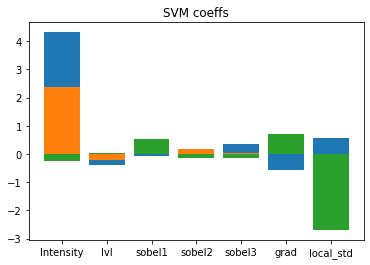

In [13]:
import matplotlib.pyplot as plt

plt.bar(f_name, clf.coef_.squeeze()[0,:])
plt.bar(f_name, clf.coef_.squeeze()[1,:])
plt.bar(f_name, clf.coef_.squeeze()[2,:])
plt.title('SVM coeffs')

(3, 7)

## Gradient Boosting

In [14]:
from sklearn.ensemble import GradientBoostingClassifier

tuned_parameters = {'loss': ['deviance'],
                    'learning_rate': [0.1, 1],
                    'n_estimators': [10, 100],
                    'max_depth': [1,2,3,4,5]}


clf = GridSearch(GradientBoostingClassifier(), tuned_parameters, scoring='accuracy')


# Tuning hyper-parameters

Best parameters set found on development set:
{'learning_rate': 1, 'loss': 'deviance', 'max_depth': 5, 'n_estimators': 100}
Grid scores on development set:
0.764 (+/-0.019) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 1, 'n_estimators': 10}
0.852 (+/-0.018) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 1, 'n_estimators': 100}
0.826 (+/-0.015) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 10}
0.862 (+/-0.021) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 2, 'n_estimators': 100}
0.846 (+/-0.025) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 10}
0.871 (+/-0.013) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 3, 'n_estimators': 100}
0.852 (+/-0.022) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 10}
0.872 (+/-0.013) for {'learning_rate': 0.1, 'loss': 'deviance', 'max_depth': 4, 'n_estimators': 100}
0.860 (+/-0.0

## Random forest (iLastik default)


In [18]:
from sklearn.ensemble import RandomForestClassifier

tuned_parameters = {'class_weight': ['balanced', None],
                    'n_estimators': [50, 100, 500]}

clf = GridSearch(RandomForestClassifier(), tuned_parameters, scoring='f1_macro')


# Tuning hyper-parameters

Best parameters set found on development set:


{'class_weight': None, 'n_estimators': 500}


Grid scores on development set:
0.848 (+/-0.039) for {'class_weight': 'balanced', 'n_estimators': 50}
0.850 (+/-0.019) for {'class_weight': 'balanced', 'n_estimators': 100}
0.851 (+/-0.020) for {'class_weight': 'balanced', 'n_estimators': 500}
0.848 (+/-0.029) for {'class_weight': None, 'n_estimators': 50}
0.849 (+/-0.034) for {'class_weight': None, 'n_estimators': 100}
0.854 (+/-0.020) for {'class_weight': None, 'n_estimators': 500}
Detailed classification report:
The model is trained on the full development set.
The scores are computed on the full evaluation set.
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       597
           1       0.93      0.86      0.89       272
           2       0.76      0.77      0.76       211

    accuracy                           0.89      1080
   macro avg       0.87      0.86  

In [20]:
import napari

def display_segmentation(u, lmap, vdim=2):
    with napari.gui_qt():
        viewer = napari.Viewer(ndisplay=vdim)
        # add the volume
        viewer.add_image(u, name='Intensity image')
        # add labels
        viewer.add_labels(lmap, name='segmentation')

def predict_and_display(apr, parts, clf, x):
    data = np.array(pyapr.numerics.reconstruction.recon_pc(apr, parts), copy=False)
    y_pred = clf.predict(x)
    mask = np.array(parts, copy=False)
    for i, elem in enumerate(y_pred):
        mask[i] = elem
    labels = np.array(pyapr.numerics.reconstruction.recon_pc(apr, parts), copy=False)
    display_segmentation(data, labels)

In [21]:
pyapr.io.read(fpath_apr, apr, parts)
predict_and_display(apr, parts, clf, scale(f))

/home/jules/anaconda3/envs/LibAPR/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:174: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "
/home/jules/anaconda3/envs/LibAPR/lib/python3.8/site-packages/sklearn/preprocessing/_data.py:191: UserWarning: Numerical issues were encountered when scaling the data and might not be solved. The standard deviation of the data is probably very close to 0. 
  warnings.warn("Numerical issues were encountered "
